<a href="https://colab.research.google.com/github/jmestanza/time_stretching/blob/master/refactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd /content
from IPython.display import clear_output

#imports
#!pip install librosa
!pip install webrtcvad
import webrtcvad
!pip install --upgrade librosa
import librosa 
import scipy
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
from math import ceil 
import matplotlib.patches as mpatches

#local modules
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/detect_pitch.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/modified_psola_op.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/vad.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/utils.py
#audios
!wget "https://raw.githubusercontent.com/vicaub/Pitch-Estimation-and-Voicing-Detection/master/data/fda_ue/rl047.wav"
!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/harry_potter_es.wav"
!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/hunger_games_en.wav"
!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/shh.wav"

clear_output()

In [0]:
from modified_psola_op import modified_psola
from detect_pitch import get_fundamental_frequency
from vad import float2pcm, pcm2float, frame_generator, join_vad_frames, get_vad_frames
from vad import Frame
from scipy import signal
from utils import plot_voiced_regs, separate_regions,get_float_and_int_audio, vad_config,get_regions_in_new_time,get_K_and_L,plot_four_signals

clear_output()

## Escuchamos el input

In [2]:
fs = 48000

audio = "/content/hunger_games_en.wav"
Audio(data=audio, rate=fs)

In [0]:
def lpc_filtering(regions_lpc, audio_f, audio_noised, coef_number): 
    lpc_coeffs = []
    error = []
    for start, end in regions_lpc:
        a = librosa.lpc(audio_noised[start:end], coef_number)
        lpc_coeffs.append(a)
        error.extend(scipy.signal.lfilter(a, [1], audio_f[start:end]))
    error = np.array(error)
    return error, lpc_coeffs

def process_error(error, K, L, fs,percent_peak,percent_pitch,speed,is_voiced,regions):
    f0_idx,f0 = get_fundamental_frequency(error,is_voiced, K, L, fs)
    psola_error, pitch_zones, unvoiced_zones = modified_psola(error, 
                                                              f0_idx,
                                                              f0,
                                                              percent_peak,
                                                              percent_pitch,
                                                              speed,
                                                              is_voiced,
                                                              regions, 
                                                              "pitch_variable",
                                                              "2")
                            #(    x, f0_idx, f0, percent, speed, is_voiced, regions, unvoiced_samples=360):

    return psola_error, f0_idx, f0 , pitch_zones, unvoiced_zones

def get_noise_for_lpc(audio_f,std = 0.001):
    noise = np.random.normal(0, std, size=len(audio_f)) # media 0
    return noise+audio_f 


In [0]:
# este SpeedUp agrega ruido a la senial para obtener LPC
# y despues filtra la senial + ruido,
# POSIBLES MEJORAS: 
# 1) se podria filtrar solo  la senial en vez de senial mas ruido pero quedarse
# de todas formas con los coeficientes lpc esos.

def speed_up(audio_path, speed, sample_rate, T=20*1e-3, cut = None):
    audio_f, audio_i = get_float_and_int_audio(audio_path,fs, cut_audio = cut) # audio_i lo necesita el VAD
    audio_noised = get_noise_for_lpc(audio_f, std=0.5) # 20e-2
    
    K , L = get_K_and_L(T,fs)

    speech, not_speech, is_voiced, frame_len = vad_config(audio_i, fs)

    regions = separate_regions(is_voiced)
    print(regions)
    regions_lpc = regions.copy()
    error, lpc_coeffs = lpc_filtering(regions_lpc, audio_f, audio_noised, coef_number=12) 
    percent_peak = 0.5
    percent_pitch = 0.5
    psola_error, f0_idx, f0, pitch_zones, unvoiced_zones =  process_error(error, K, L, fs,percent_peak,percent_pitch,speed,is_voiced,regions)
    print(pitch_zones)
    sub_regions = get_regions_in_new_time(regions_lpc,speed, mode= "floor")

    voiced_filt = []            

    for i, sub_reg in enumerate(sub_regions):      
        start, end = sub_reg
        voiced_filt.extend(scipy.signal.lfilter([1], lpc_coeffs[i] , psola_error[start:end]))
    voiced_filt = np.array(voiced_filt)
    
    is_voiced = np.array(is_voiced)
    is_voiced = is_voiced.astype(np.int16)

    return voiced_filt, psola_error, error, audio_f, is_voiced, pitch_zones, unvoiced_zones

periodicidad minima que se puede estimar 100.0 Hz
[[0, 1919], [1920, 13439], [13440, 49919], [49920, 124799], [124800, 142079]]
[[2161, 2161], [2466, 3240], [3165, 3835], [3820, 4578], [4229, 4987], [4630, 5452], [5246, 6068], [5795, 6647], [6234, 7086], [6728, 7400], [7292, 7964], [7638, 8482], [8450, 9130], [8832, 9532], [9484, 10184], [9949, 10701], [10534, 11286], [11135, 11903], [11659, 12351], [12309, 12963], [12714, 13368], [50142, 50848], [50545, 51251], [50900, 51606], [51378, 52088], [51851, 52567], [52526, 53254], [52963, 53691], [53615, 54333], [54031, 54749], [54443, 55161], [54853, 55571], [55465, 56183], [56075, 56793], [56475, 57193], [56890, 57610], [57522, 58242], [57950, 58664], [58374, 59088], [59032, 59754], [59465, 60187], [59899, 60621], [60341, 61053], [60787, 61499], [61243, 61953], [61702, 62412], [62409, 63121], [62893, 63605], [63388, 64096], [63885, 64593], [64380, 65084], [64865, 65581], [65594, 66310], [66315, 67031], [66786, 67494], [67494, 68196], [6795

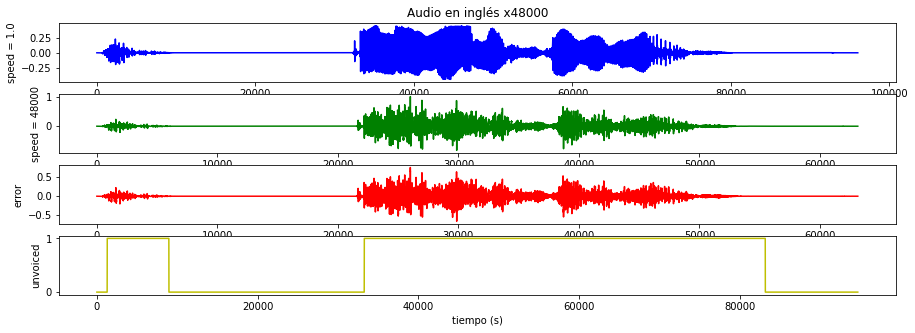

In [91]:
speed = 1.5
audio_final, psola_err, err, audio_original, is_voice, pz, uz = speed_up(audio, speed, fs, cut = 3) # hacemos los primeros 10 segundos
plot_four_signals(audio_original,audio_final,psola_err,is_voice,speed,fs)
Audio(data=audio_final, rate=fs)

[[120, 840], [480, 1200], [840, 1560], [1200, 1920], [1560, 2280], [1920, 2640], [2280, 3000], [2640, 3360], [3000, 3720], [3360, 4080], [3720, 4440], [4080, 4800], [4440, 5160], [4800, 5520], [5160, 5880], [5520, 6240], [5880, 6600], [6240, 6960], [6600, 7320], [6960, 7680], [7320, 8040], [7680, 8400], [8040, 8760], [8400, 9120], [8760, 9480], [9120, 9840], [9480, 10200], [9840, 10560], [10200, 10920], [10560, 11280], [10920, 11640], [11280, 12000], [11640, 12360], [12000, 12720], [12360, 13080], [12720, 13440], [13080, 13800], [13440, 14160], [13800, 14520], [14160, 14880], [14520, 15240], [14880, 15600], [15240, 15960], [15600, 16320], [15960, 16680], [16320, 17040], [16680, 17400], [17040, 17760], [17400, 18120], [17760, 18480], [18120, 18840], [18480, 19200], [18840, 19560], [19200, 19920], [19560, 20280], [19920, 20640], [20280, 21000], [20640, 21360], [21000, 21720], [21360, 22080], [21720, 22440], [22080, 22800], [22440, 23160], [22800, 23520], [23160, 23880], [23520, 24240], [

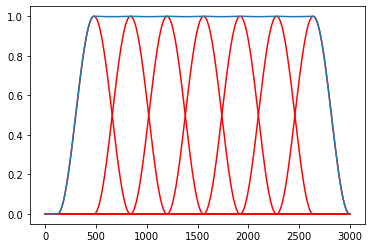

In [77]:
time = np.linspace(0, len(audio_final)//fs, 3000)

print(uz)
suma = np.zeros(len(time))
for reg in uz:
    start,end = reg

    if end <= 3000:
        y = np.zeros(len(time))
        w = np.hanning(end-start)
        y[start:end] = w
        suma[start:end] += w
        plt.plot(y,"r")

plt.plot(suma)
# plt.show()

[[2161, 2161], [2466, 3240], [3165, 3835], [3820, 4578], [4229, 4987], [4630, 5452], [5246, 6068], [5795, 6647], [6234, 7086], [6728, 7400], [7292, 7964], [7638, 8482], [8450, 9130], [8832, 9532], [9484, 10184], [9949, 10701], [10534, 11286], [11135, 11903], [11659, 12351], [12309, 12963], [12714, 13368], [50142, 50848], [50545, 51251], [50900, 51606], [51378, 52088], [51851, 52567], [52526, 53254], [52963, 53691], [53615, 54333], [54031, 54749], [54443, 55161], [54853, 55571], [55465, 56183], [56075, 56793], [56475, 57193], [56890, 57610], [57522, 58242], [57950, 58664], [58374, 59088], [59032, 59754], [59465, 60187], [59899, 60621], [60341, 61053], [60787, 61499], [61243, 61953], [61702, 62412], [62409, 63121], [62893, 63605], [63388, 64096], [63885, 64593], [64380, 65084], [64865, 65581], [65594, 66310], [66315, 67031], [66786, 67494], [67494, 68196], [67957, 68667], [68657, 69367], [69122, 69836], [69836, 70550], [70319, 71033], [70813, 71527], [71214, 71932], [71570, 72288], [7207

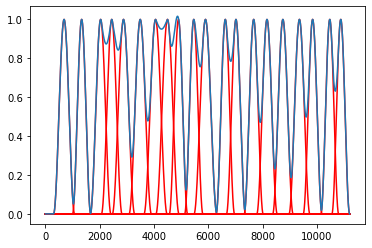

In [92]:
cant_ventanas = 20
start_0 = pz[0][0]
end_0 = pz[cant_ventanas][1]+1
# agarro 20 de las regiones con pitch
print(pz)
suma = np.zeros(end_0-start_0)
print(len(suma))
for reg in pz:
    start,end = reg
    if start_0 <= start and end <= end_0:
        y = np.zeros(len(suma))
        w = np.hanning(end-start)
        y[start-start_0:end-start_0] = w
        suma[start-start_0:end-start_0] += w
        plt.plot(y,"r")

plt.plot(suma)

## Vamos a hacer LPC short time 

In [0]:
def LPC_short_time_filter(audio_f,window_size, apply_hanning = True):
    leap = window_size // 2
    lpc_coeffs = []
    cnt_leaps = len(audio_f) // leap 
    error = np.zeros(len(audio_f))

    for i in range(cnt_leaps):
        curr_rw = audio_f[i*leap : (i+1)*leap+leap] # overlap de 50%
        if apply_hanning:
            hanning_w = np.hanning(len(curr_rw))
            curr_rw *= hanning_w
        a = librosa.lpc(curr_rw, 12)
        lpc_coeffs.append(a)
        error[i*leap : (i+1)*leap+leap] += scipy.signal.lfilter(a, [1], curr_rw)
    
    return error, lpc_coeffs

def LPC_short_time_defilter(psola_err, speed, lpc_coeffs, window_size, apply_hanning = True):
    leap = window_size // 2
    cnt_leaps = len(psola_err) // leap 
    final_audio = np.zeros(len(psola_err))
    num, den = speed.as_integer_ratio() # 3 / 2 = > num 3 , den 2 ;  4 1 

    new_lpc_coeffs = []
    for i in range(len(lpc_coeffs)):
        if den> i%num:
            new_lpc_coeffs.append(lpc_coeffs[i])

    for i in range(cnt_leaps):
        curr_rw = psola_err[i*leap : (i+1)*leap+leap] # overlap de 50%
        if apply_hanning:
            hanning_w = np.hanning(len(curr_rw))
            curr_rw *= hanning_w
        final_audio[i*leap : (i+1)*leap+leap] += scipy.signal.lfilter([1], new_lpc_coeffs[i], curr_rw)
    return final_audio

In [36]:
# este SpeedUp agrega ruido a la senial para obtener LPC
# y despues filtra la senial + ruido,
# POSIBLES MEJORAS: 
# 1) se podria filtrar solo  la senial en vez de senial mas ruido pero quedarse
# de todas formas con los coeficientes lpc esos.

def speed_up_with_LPC_ST(audio_path, speed, sample_rate, T=20*1e-3):
    audio_f, audio_i = get_float_and_int_audio(audio_path,fs, cut_audio = 4) # audio_i lo necesita el VAD
    audio_f = get_noise_for_lpc(audio_f, std=1e-3)

    K , L = get_K_and_L(T,fs)

    speech, not_speech, is_voiced, frame_len = vad_config(audio_i, fs)
    
    regions = separate_regions(is_voiced)
    regions_lpc = regions.copy()

    window_size = int(75e-3*fs)
    error, lpc_coeffs = LPC_short_time_filter(audio_f,window_size, apply_hanning = False)
    
    percent = 0.5
    psola_error, f0_idx, f0, pitch_zones, unvoiced_zones =  process_error(error, K, L, fs,percent,speed,is_voiced,regions)    
    
    voiced_filt =  LPC_short_time_defilter(psola_error, speed, lpc_coeffs, window_size, apply_hanning = True)

    return voiced_filt, psola_error, error, audio_f 

speed = 2.0
audio_final, psola_err, err, audio_original = speed_up_with_LPC_ST(audio, speed, fs)
#plot_three_signals(audio_original,audio_final,psola_err, speed,normalize = False, fill_with_zeros=False)
Audio(data=audio_final, rate=fs)

periodicidad minima que se puede estimar 100.0 Hz
Estoy en psola
Estoy en un frame de no speech
Estoy en un frame de speech
724
Estoy en un frame de no speech
Estoy en un frame de speech
714
Estoy en un frame de no speech
Estoy en un frame de speech
720
Estoy en un frame de no speech


## Conclusiones hasta ahora

* Filtrado LPC provoca picos extraños en la señal 

* Filtrado LPC SHORT TIME no mejora respecto al que propusimos que era por separacion de regiones sonoras (LPC SHORT TIME toma ventanas)

Como se hizo LPC SHORT TIME:

Filtrado:

Agarre una ventana rectangular, la filtre con el error de prediccion y eso lo puse como error cada 20ms y con overlap de 50%.

Defiltrado del error de psola:

Ventanee con hanning overlap de 50%, la filtre con el inverso del filtro de error de prediccion.

*  Bug de volumen en PSOLA

## Conclusiones hasta ahora 2 
filtrado LPC provocaba picos extraños en la señal y además introducía un cambio en el volumen.

Para solucionar esto, añadimos un parámetro de regularización por medio de añadir ruido blanco al audio, regulando la varianza pudimos mejorar esta condición de LPC. 

## Conclusiones hasta ahora 3
habia un bug en regions